In [1]:
### importing libraries
import pandas as pd
import numpy as np
from sklearn import linear_model

#### To load a new data set and predict a given  meet using that data set
###### ----These steps are not needed if test set and training set is already avaiable----
###### ---- Start----

In [3]:
## loading the dataset
dataset = pd.read_csv('/Users/VP/Downloads/final_boys_modelling_days_bet.csv')

In [45]:
### fixing the runner id problem in the data set
#dataset['RunnerID_1'] = dataset['RunnerID'].str.split("-").str[0]
#dataset['RunnerID_1'].fillna(dataset['RunnerID'],inplace = True)
#dataset['RunnerID_1']
#dataset = dataset.drop('RunnerID',axis = 1)
#dataset = dataset.rename(columns ={ 'RunnerID_1' :'RunnerID'})
## converting the classification as categor
 
dataset['Classification'] = dataset['Classification'].astype("category")
dataset['Classification_cat'] = dataset['Classification'].cat.codes


In [5]:
## creatin the validation dataset - containing one meet
## since we need to calculate students performance for one meet, we are removing a particular meet as validation (test set)
## this meet has around 163 participants. 
validation = dataset[(dataset['DATE'] == '10/10/15') & (dataset['meet'] == 'NCRunners Elite Cross Country Invitational')]


In [6]:
## removing the validation data frm the training dataset
dataset2 = dataset.drop((dataset['DATE'] == '10/10/15') & (dataset['meet'] == 'NCRunners Elite Cross Country Invitational'))
#dataset2 = pd.merge(dataset,validation[['RunnerID']],on = "RunnerID")
dataset2.head()

,ID,RunnerID,first,last,school,class_status_cat,class_status_num,time_sec,time_dec_min,Classification,...,LONGITUDE,HOURLYDRYBULBTEMPF,HOURLYRelativeHumidity,year,Temp_Celcius,Dew_Point_Celc,Elevation_Cat,Dew_Point_Cat,Days_Bet_Races,Classification_cat
2,25205,111706,Chase,Shermer,North Raleigh Christian Academy,Junior,3,1042.00,17.367,3A,...,-78.7819,66.0,26.0,2010.0,18.88888889,-1.044245964,1,1.0,27,2
3,16296,111706,Chase,Shermer,North Raleigh Christian Academy,Junior,3,1048.00,17.467,3A,...,-82.5375,60.0,19.0,2010.0,15.55555556,-8.007984925,3,1.0,7,2
4,65000,111706,Chase,Shermer,North Raleigh Christian Academy,Junior,3,1003.37,16.723,3A,...,-79.9432,43.0,42.0,2010.0,6.111111111,-5.856571325,2,1.0,9,2
5,62270,111706,Chase,Shermer,North Raleigh Christian Academy,Junior,3,1048.00,17.467,3A,...,-80.9552,45.0,35.0,2010.0,7.222222222,-7.240404938,1,1.0,20,2
6,56855,111706,Chase,Shermer,North Raleigh Christian Academy,Senior,4,1025.00,17.083,3A,...,-80.9552,80.0,76.0,2011.0,26.66666667,22.08547276,1,5.0,280,2


#### get the mean time, std deviation time  and min time for each player in the dataset

In [7]:
### getting the minimum time , average and std of each player in the data set
timedetails = dataset2.groupby(['RunnerID']).agg({'time_sec':{"time_sec_min":"min","time_sec_mean" :"mean","time_sec_std" : "std"}}).reset_index()
timedetails.head()

/anaconda/lib/python2.7/site-packages/pandas/core/groupby.py:3961: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


RunnerID      time_sec                          
           time_sec_mean time_sec_std time_sec_min
0   111706   1032.342308    39.013504        977.3
1   131372   1055.966667    22.810347       1020.4
2   180821   1055.176923    27.132243       1016.0
3   185469   1049.569231    34.929653       1010.0
4   236627   1133.153077    44.344666       1060.4

In [8]:
## adding the  the minimum time, std  and average for each player in the training set
dataset1 = pd.merge(timedetails,dataset2,on = "RunnerID",how = "right")

/anaconda/lib/python2.7/site-packages/pandas/core/reshape/merge.py:551: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


In [9]:
## adding the min time and average time for each player in validation set
validation1 = pd.merge(timedetails,validation,on = "RunnerID",how = "right")
validation1.to_csv("/Users/VP/Downloads/validationRunner.csv")
dataset1.to_csv("/Users/VP/Downloads/datasetRunner.csv")

#### -----End - data preparation step---

### Start the prediction from here

In [17]:
## loading the data
validation = pd.read_csv("/Users/VP/Downloads/validationRunner.csv")
dataset = pd.read_csv("/Users/VP/Downloads/datasetRunner.csv")

##### filtering  the features required for prediction

In [18]:
### fixing the columns to use for prediction
##cols = ['Classification_cat','time_sec_min','time_sec_mean','time_sec_std']
cols = ['Classification_cat','time_sec_min','time_sec_mean','time_sec_std','Temp_Celcius','ELEVATION' , 'Dew_Point_Celc']

Imputing the dataset,missing values and conversion of categorical variables. 

In [19]:
## filling in the null values and converting the elevation and dew point as categories
dataset.Temp_Celcius.fillna(dataset['Temp_Celcius'].mean(),inplace =True)
from sklearn import preprocessing
dataset['Elevation_Cat'] = dataset['Elevation_Cat'].astype("category")
dataset['Dew_Point_Cat'] = dataset['Dew_Point_Cat'].astype("category")
dataset.ELEVATION.fillna(dataset['ELEVATION'].mean(),inplace =True)
dataset.Dew_Point_Celc.fillna(dataset['Dew_Point_Celc'].mean(),inplace =True)
## convert region in NC to a categorical variable
dataset['RegioninNC'] = dataset['RegioninNC'].astype("category")
dataset['RegioninNC_cat'] = dataset['RegioninNC'].cat.codes
dataset.RegioninNC_cat.fillna(1,inplace =True)
## convert classfication to a categorical variable
dataset.Dew_Point_Cat.fillna(2,inplace =True)
## converting runnerid as category
dataset['RunnerID'] = dataset['RunnerID'].astype("category")
# Training data
X = dataset[cols]
## Training label 
y = dataset[['time_sec']]
## standardizing the data in the training set ( It does not produce much effect though!)
standardized_X = preprocessing.scale(X)


Fitting the linear model

In [20]:
## fitting the linear model
lm = linear_model.LinearRegression()
model = lm.fit(X,y)


In [43]:
## making changes in the elevation and category values 
validation.Temp_Celcius.fillna(validation['Temp_Celcius'].mean(),inplace =True)
validation['Classification_cat'] = validation['Classification_cat'].astype("category")
validation['Elevation_Cat'] = validation['Elevation_Cat'].astype("category")
validation['Dew_Point_Cat'] = validation['Dew_Point_Cat'].astype("category")
## region in NC to category
validation['RegioninNC'] = validation['RegioninNC'].astype("category")
validation['RegioninNC_cat'] = validation['RegioninNC'].cat.codes
validation.RegioninNC_cat.fillna(1,inplace =True)
# use the same columns as that of the training dataset. 
validation[cols]
validation.ELEVATION.fillna(validation['ELEVATION'].mean(),inplace =True)
validation.Dew_Point_Celc.fillna(validation['Dew_Point_Celc'].mean(),inplace =True)
validation['RunnerID'] = validation['RunnerID'].astype("category")


In [22]:
## printing  equation coefficients. 
lm.coef_
#cols = ['RunnerID','Classification_cat','time_sec_min','time_sec_mean','time_sec_std','Temp_Celcius','ELEVATION' , 'Dew_Point_Celc']

array([[-1.1876687 ,  0.01427867,  0.95235025,  0.01767753,  2.86575491,
         0.03912429,  1.7107198 ]])

predicting the data for test data (NCRunners Elite XC invitational)

In [23]:
## predicting the validation data
X_new = validation[cols]
standardized_X_new = preprocessing.scale(X_new)
predictions = lm.predict(X_new)
## to see the difference between the actual and predicted times
len(predictions)
prediction_df = pd.DataFrame(predictions)
prediction_df = prediction_df.rename(columns = {0 : "predicted_time_sec"})
prediction_df
validation
frames = [validation, prediction_df]
result = pd.concat(frames,axis=1)
result[['RunnerID','time_sec','predicted_time_sec']].tail()

/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:177: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


,RunnerID,time_sec,predicted_time_sec
700,5610202,1126.0,1222.815407
701,5652319,1058.5,1023.148269
702,5722437,1042.6,1084.906485
703,6319431,1088.3,1108.866299
704,6319441,1091.2,1126.331876


In [24]:
## calculating score
from sklearn.metrics import r2_score
Y_true = validation['time_sec']
Y_pred = predictions
lm.score(X,y)

0.76436504517808168

In [25]:
test1 = result["time_sec"].values
test2 = result["predicted_time_sec"].values
test3 = test1 - test2


#976.68314568536516
#result[result['time_sec'] == a]

##### Calculating top  7 champions in the meet

In [26]:
## actual Top 7 teams 
smallestTime = pd.DataFrame(result.groupby(['school'])['time_sec'].nsmallest(7)).reset_index()
smallestTimeAvg = pd.DataFrame(smallestTime.groupby('school')['time_sec'].mean())
smallestTimeAvg.time_sec.nsmallest(7)


school
North Raleigh Christian Academy     976.590000
Cleveland High School               986.950000
Cape Fear                           994.400000
Weddington High School              999.357143
Brevard                            1001.000000
Forbush                            1009.500000
Green Hope                         1013.000000
Name: time_sec, dtype: float64

In [27]:
# predicted top 7 teams
smallestTime = pd.DataFrame(result.groupby(['school'])['predicted_time_sec'].nsmallest(7)).reset_index()
smallestTimeAvg = pd.DataFrame(smallestTime.groupby('school')['predicted_time_sec'].mean())
smallestTimeAvg.predicted_time_sec.nsmallest(7)

school
Cape Fear                           982.426271
North Raleigh Christian Academy     987.288948
Cleveland High School              1000.929875
Brevard                            1001.845824
Forbush                            1016.811339
East Chapel Hill                   1028.285608
Weddington High School             1030.408053
Name: predicted_time_sec, dtype: float64

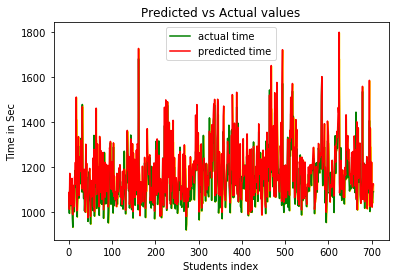

In [28]:
import matplotlib.pyplot as plt
plt.clf
plt.title("Predicted vs Actual values")
plt.plot(X_new.index.values, Y_true,  color='green', label = "actual time")
plt.plot(X_new.index.values, Y_pred, color='red',label = "predicted time")
X_new1 = pd.DataFrame(X_new.index.values)
k = np.array(X_new1)
Y = pd.DataFrame(Y_pred)
Y1 = np.array(Y[0])
plt.legend()
plt.xlabel("Students index")
plt.ylabel("Time in Sec")
plt.rcParams['figure.figsize'] = (10,6)
plt.fill_between( X_new.index.values, Y1, Y_true , color = 'gold',alpha = 1)
plt.show()

/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


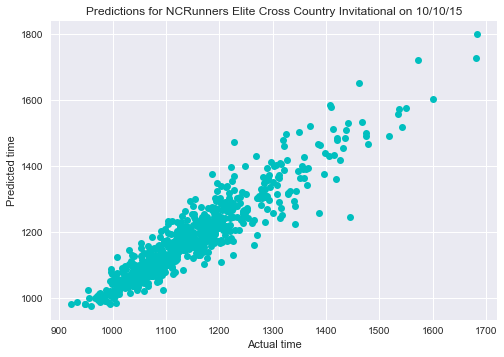

In [29]:
import seaborn as sns
plt.clf
plt.legend()
plt.title("Predictions for NCRunners Elite Cross Country Invitational on 10/10/15")
plt.xlabel("Actual time")
plt.ylabel("Predicted time")
plt.rcParams['figure.figsize'] = (10,6)
plt.plot(Y_true, Y_pred,'co')
#sns.regplot(x="time_sec", y="predicted_time_sec", data=result,color='g');
plt.show()

In [30]:
from sklearn.feature_selection import f_regression
f_test, _ = f_regression(X,dataset['time_sec'])
f_test /= np.max(f_test)
f_test


array([  6.12308256e-03,   7.08159948e-01,   1.00000000e+00,
         1.18692768e-01,   3.15962793e-02,   2.70929110e-04,
         1.97268314e-02])

In [31]:
cols

['Classification_cat',
 'time_sec_min',
 'time_sec_mean',
 'time_sec_std',
 'Temp_Celcius',
 'ELEVATION',
 'Dew_Point_Celc']

## MODEL 2 - using OLS 

In [32]:
## this model is to get the summary format of the model
import pandas as pd
import statsmodels.formula.api as sm
import statsmodels.regression.linear_model as ols

In [33]:
#df = pd.DataFrame({"A": [10,20,30,40,50], "B": [20, 30, 10, 40, 50], "C": [32, 234, 23, 23, 42523]})
result = sm.ols(formula= "time_sec ~ time_sec_mean + time_sec_std + Temp_Celcius + ELEVATION + Dew_Point_Celc " , data=dataset).fit()
#result = sm.ols(formula= "time_sec ~  Classification_cat  + time_sec_mean + time_sec_std+ Temp_Celcius    ", data=dataset).fit()

In [44]:
y_hat_no_int = result.predict(validation[cols])

In [35]:
result.rsquared

0.76432464576264159

In [36]:
result.params

Intercept        -54.101429
time_sec_mean      0.965985
time_sec_std       0.008456
Temp_Celcius       2.855936
ELEVATION          0.039978
Dew_Point_Celc     1.710891
dtype: float64

In [37]:
result.pvalues

Intercept          1.211688e-75
time_sec_mean      0.000000e+00
time_sec_std       3.151503e-01
Temp_Celcius       0.000000e+00
ELEVATION          7.347303e-97
Dew_Point_Celc    1.315523e-150
dtype: float64

### Regression Summary

In [39]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               time_sec   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                 4.774e+04
Date:                Wed, 09 Aug 2017   Prob (F-statistic):               0.00
Time:                        22:52:07   Log-Likelihood:            -4.2930e+05
No. Observations:               73613   AIC:                         8.586e+05
Df Residuals:                   73607   BIC:                         8.587e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -54.1014      2.936    -18.426      0.000     -59.856     -48.346
time_sec_mean      0.9660      0.003    371.354      0.000       0.961       0.971
time_sec_std       0.0085      0.008      1.004      0.315      -0.008       0.025
Temp_Celcius       2.8559      0.069     41.153      0.000       2.720       2.992
ELEVATION          0.0400      0.002     20.916      0.000       0.036       0.044
Dew_Point_Celc     1.7109      0.065     26.200      0.000       1.583       1.839
==============================================================================
Omnibus:                    48644.229   Durbin-Watson:                   1.498
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2958085.756
Skew:                           2.504   Prob(JB):                         0.00
Kurtosis:                      33.649   Cond. No.                     1.21e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.21e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [46]:
len(dataset.school.unique().tolist())

367

In [47]:
len(dataset.ID.unique().tolist())

73613